### Problem Statement

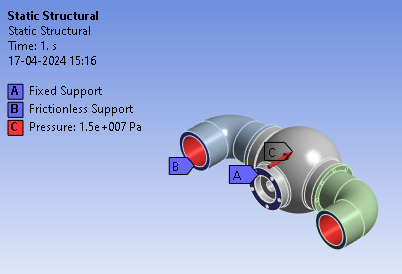

### Imports

In [1]:
import os
from ansys.mechanical.core import embedding as app
from ansys.mechanical.core import global_variables

### Input Parameters : Folders . Ansys Version

In [2]:
inputs_dir = os.path.join(os.getcwd(),"inputs")
geom_file_name = "Valve_Geometry_NS.scdoc"
mat_file_name = "MatML2.xml"
mechdat_file_name = "embedded_nb_200.mechdb"

outputs_dir = os.path.join(os.getcwd(),"outputs")
work_dir = os.path.join(os.getcwd(),"wdir")

ansys_version = 241

### Construct Absolute File paths

In [3]:
#Geometry file with Named Selections Defined
geometryfilewithpath = os.path.join(inputs_dir,geom_file_name )

#Materials file (Select Multiple Materials in Engg Data > Export)
matfilewithpath = os.path.join(inputs_dir, mat_file_name)

# File name to save (Standalone Mechanical uses Mechdb and Mechdat)
mechdat_filepath = os.path.join(work_dir, mechdat_file_name) # edit this filename

### Create an Embedded Instance of Mechanical

In [4]:

e_app = app.App(version=ansys_version)
print(e_app)
globals().update(global_variables(e_app, True))


Ansys Mechanical [Ansys Mechanical Enterprise]
Product Version:241
Software build date: 11/27/2023 12:02:06



### Import Geometry and Materials

In [5]:

"""Import board geometry with specified settings"""
geometry_import = Model.GeometryImportGroup.AddGeometryImport()
geometry_import_format = (Ansys.Mechanical.DataModel.Enums.GeometryImportPreference.Format.Automatic)
geometry_import_preferences = (Ansys.ACT.Mechanical.Utilities.GeometryImportPreferences())
geometry_import_preferences.NamedSelectionKey = ""
geometry_import_preferences.ProcessNamedSelections = True
geometry_import.Import(geometryfilewithpath, geometry_import_format, geometry_import_preferences)

"""Import Materials from xml file created from Engineering Data"""
Model.Materials.Import(matfilewithpath)
e_app.save(mechdat_filepath)


### Verify : Count of Bodies and Names of Materials

In [6]:

allbodies=ExtAPI.DataModel.Project.Model.GetChildren( Ansys.Mechanical.DataModel.Enums.DataModelObjectCategory.Body,True)
print("\nTotal Number of Bodies : ", allbodies.Count)

print("Materials available : ")
for mat in Model.Materials.Children:
    print(mat.Name)




Total Number of Bodies :  3
Materials available : 
Structural Steel
Gray Cast Iron


### Assign a different material to a body

In [7]:
part =  ExtAPI.DataModel.GetObjectsByName("Connector")[0]
part.Material = "Gray Cast Iron"
ExtAPI.DataModel.Tree.Refresh()

e_app.save(mechdat_filepath)

### Assign Mesh Settings. Generate Mesh

In [8]:
# Define mesh settings
mesh = Model.Mesh
mesh.ElementSize = Quantity('25 [mm]')
mesh.GenerateMesh()



### Assign Loads and Boundary Conditions 

In [9]:

# Define boundary conditions:
analysis = Model.AddStaticStructuralAnalysis()

fixedSupport = analysis.AddFixedSupport()
fixedSupport.Location = ExtAPI.DataModel.GetObjectsByName("NSFixedSupportFaces")[0]

frictionlessSupport = analysis.AddFrictionlessSupport()
frictionlessSupport.Location = ExtAPI.DataModel.GetObjectsByName("NSFrictionlessSupportFaces")[0]

pressure = analysis.AddPressure()
pressure.Location = ExtAPI.DataModel.GetObjectsByName("NSInsideFaces")[0]
pressure.Magnitude.Inputs[0].DiscreteValues = [Quantity("0 [s]"), Quantity("1 [s]")]
pressure.Magnitude.Output.DiscreteValues = [Quantity("0 [Pa]"), Quantity("15 [MPa]")]

e_app.save(mechdat_filepath)

### Solve and Save

In [10]:

# Solve model
analysis.Solve()

e_app.save(mechdat_filepath)

### Add Result Objects . Evaluate . Export Results as a text file .

In [11]:

# Add results
solution = analysis.Solution
solution.AddTotalDeformation()
solution.AddEquivalentStress()
solution.EvaluateAllResults()
e_app.save(mechdat_filepath)

# Export result values to a text file
results =  solution.GetChildren(DataModelObjectCategory.Result,True)
for result in results:
    fileName = str(result.Name)
    path = os.path.join(outputs_dir,fileName+r".txt")
    result.ExportToTextFile(True,path)


C:\Users\rkokkili\AppData\Local\Temp\ipykernel_20452\261484581.py:13: UserWarning: Obsolete: 'ExportToTextFile': Remove bIgnoreExcelPreference parameter
  result.ExportToTextFile(True,path)


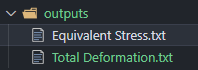

### Close the Embedded Instance

In [12]:
e_app.close()